In [1]:
#using Pkg; Pkg.add("StatsPlots")

In [1]:
using ITensors
using Plots
using QuadGK # for 1D integrals
        #example: quadgk(x -> exp(-x^2), 0, 1, rtol=1e-8)
using LinearAlgebra
using LaTeXStrings # L"string" to print "string" as latex
#using LsqFit # for nonlinear fit https://julianlsolvers.github.io/LsqFit.jl/latest/tutorial/

using Polynomials #there is a function `fit(xdata,ydata,polynomial_degree)` to do polynomial regression. 
                    #Source: https://www.geeksforgeeks.org/polynomial-regression-in-julia/
using Dates #to use the function now()
#using HDF5 #to save weird objects
using LsqFit #for nonlinear fits
using CSV
using JLD2
using DataFrames
using Formatting #i'm using this to obtain a string from a float WITHOUT scientific notation
#using StatsPlots, StatsPlots.PlotMeasures

In [2]:
Threads.nthreads()

1

# Importing data

In the following cell we define the evolution with the Hamiltonian

$$ H = \sum_{i=2}^{L-1}
\frac{1-\sigma^z_i}{2} \left(
J_x\sigma_{i-1}^x \sigma^x_{i+1} + J_y\sigma_{i-1}^y \sigma^y_{i+1} + J_z\sigma_{i-1}^z \sigma^z_{i+1}
   \right)
   - h \sum_{i=1}^{L} \sigma^z_i
 .$$
 
I have the following options for the parameters:

In [2]:
J = 1
γ = 0.5
w = 0.7
Δ = 0.0
Dz = 0.6
hz = 0.0

dt = 0.01;
Ls = [100]
bDs = [200, 300];

We'll construct the table

|  | bD1 | bD2 | bD3 |
| --- | --- | --- | ---|
| **L1** | 
| **L2**
| **L3**



In [6]:
tabb = [[["$(colons)","$(rows)"] for rows in bDs] for colons in Ls]

1-element Vector{Vector{Vector{String}}}:
 [["100", "200"], ["100", "300"]]

In [3]:
# for laptop:
#base_path = "/Users/saveriobocini/numerics_PhD/quantum_transistor/fullglory";

# for desktop
base_path = "/home/sbocini/Numerics_LabDesktop/quantum_transistor/fullglory";


times = [
    load("$(base_path)/L$(L)_J$(J)_gamma$(γ)_w$(w)_Delta$(Δ)_Dz$(Dz)_hz$(hz)_BondDim$(bDs[1])_dt$(dt).jld2"
    , "times") for L in Ls
];

states = [
    [
        [
            load("$(base_path)/L$(Ls[k])_J$(J)_gamma$(γ)_w$(w)_Delta$(Δ)_Dz$(Dz)_hz$(hz)_BondDim$(bDs[j])_dt$(dt).jld2"
                , "t$(round(times[k][i], digits=3))")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

# Observables definition

Here I define a function to compute the Hamiltonian density $\frac{1-\sigma^z_i}{2} \left(
J_x\sigma_{i-1}^x \sigma^x_{i+1} + J_y\sigma_{i-1}^y \sigma^y_{i+1} + J_z\sigma_{i-1}^z \sigma^z_{i+1}
   \right)
   - h \sigma^z_i$.
It works for $i\in\{2,...,L-1\}$.

In [4]:
function hamiltonian_density(state, i, jx=Jx, jy=Jy, jz=Jz, hh=h)
    
    if i==1 || i ==length(state) 
        throw(DomainError(i, "Trying to go beyond boundaries."))
    end
    
    orthogonalize!(state, i-1)
    
    op_site1 = jx * op(siteind(state, i-1), "Sx")
    op_site2 = -2 * op(siteind(state, i), "Sz")
    op_site3 = 2 * op(siteind(state, i+1), "Sx")
    
    C = state[i-1] #indices (link i-2) (link,i-1) (spin,i-1)
          #this selects the (i-1)-th tensor of the (un-conjugated) state
    C *= op_site1 #indices (link i-2) (link,i-1) (spin,i-1)'
          #this applies the operator op_site1 to the site that we selected on the line above
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); 
    C *= state[i];
    C *= dag(prime(state[i], "Link"));
    C *= state[i+1];
    C *=  op_site3;
    il = commonind(state[i+1],state[i]);
    C *=  dag(prime(prime(state[i+1], "Site"), il));
    outpu = C[] 
    
    C = state[i-1] #indices (link i-2) (link,i-1) (spin,i-1)
          #this selects the (i-1)-th tensor of the (un-conjugated) state
    C *= op_site1 #indices (link i-2) (link,i-1) (spin,i-1)'
          #this applies the operator op_site1 to the site that we selected on the line above
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); 
    C *= state[i];
    C *= op_site2
    C *= dag(prime(prime(state[i], "Site"), "Link"));
    C *= state[i+1];
    C *=  op_site3;
    il = commonind(state[i+1],state[i]);
    C *=  dag(prime(prime(state[i+1], "Site"), il));
    outpu += C[] 
    
    op_site1 = jy * op(siteind(state, i-1), "Sy")
    op_site2 = -2 * op(siteind(state, i), "Sz")
    op_site3 = 2 * op(siteind(state, i+1), "Sy")
    
    C = state[i-1] #indices (link i-2) (link,i-1) (spin,i-1)
          #this selects the (i-1)-th tensor of the (un-conjugated) state
    C *= op_site1 #indices (link i-2) (link,i-1) (spin,i-1)'
          #this applies the operator op_site1 to the site that we selected on the line above
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); 
    C *= state[i];
    C *= dag(prime(state[i], "Link"));
    C *= state[i+1];
    C *=  op_site3;
    il = commonind(state[i+1],state[i]);
    C *=  dag(prime(prime(state[i+1], "Site"), il));
    outpu += C[] 
    
    C = state[i-1] #indices (link i-2) (link,i-1) (spin,i-1)
          #this selects the (i-1)-th tensor of the (un-conjugated) state
    C *= op_site1 #indices (link i-2) (link,i-1) (spin,i-1)'
          #this applies the operator op_site1 to the site that we selected on the line above
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); 
    C *= state[i];
    C *= op_site2
    C *= dag(prime(prime(state[i], "Site"), "Link"));
    C *= state[i+1];
    C *=  op_site3;
    il = commonind(state[i+1],state[i]);
    C *=  dag(prime(prime(state[i+1], "Site"), il));
    outpu += C[] 
    
    op_site1 = jz * op(siteind(state, i-1), "Sz")
    op_site2 = -2 * op(siteind(state, i), "Sz")
    op_site3 = 2 * op(siteind(state, i+1), "Sz")
    
    C = state[i-1] #indices (link i-2) (link,i-1) (spin,i-1)
          #this selects the (i-1)-th tensor of the (un-conjugated) state
    C *= op_site1 #indices (link i-2) (link,i-1) (spin,i-1)'
          #this applies the operator op_site1 to the site that we selected on the line above
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); 
    C *= state[i];
    C *= dag(prime(state[i], "Link"));
    C *= state[i+1];
    C *=  op_site3;
    il = commonind(state[i+1],state[i]);
    C *=  dag(prime(prime(state[i+1], "Site"), il));
    outpu += C[] 
    
    C = state[i-1] #indices (link i-2) (link,i-1) (spin,i-1)
          #this selects the (i-1)-th tensor of the (un-conjugated) state
    C *= op_site1 #indices (link i-2) (link,i-1) (spin,i-1)'
          #this applies the operator op_site1 to the site that we selected on the line above
    ir = commonind(state[i-1], state[i]); 
    C *= dag(prime(prime(state[i-1], "Site"), ir)); 
    C *= state[i];
    C *= op_site2
    C *= dag(prime(prime(state[i], "Site"), "Link"));
    C *= state[i+1];
    C *=  op_site3;
    il = commonind(state[i+1],state[i]);
    C *=  dag(prime(prime(state[i+1], "Site"), il));
    outpu += C[] 
    
    outpu += -2hh * expect(state, "Sz", sites=i)
end

hamiltonian_density (generic function with 5 methods)

In [5]:
function edge_energy(state)
    -2h * sum(expect(state, "Sz", sites = [1,length(state)]))
end

edge_energy (generic function with 1 method)

In [6]:
function SvN_of_half_chain(state)
    L = length(state)
    b = div(L,2)
    orthogonalize!(state, b)
    U,S,V = svd(state[b], (linkind(state, b), siteind(state,b+1)))
    SvN = 0.0
    for n=1:dim(S, 1)
      p = S[n,n]^2
      SvN -= p * log(p)
    end
    SvN
end
    

SvN_of_half_chain (generic function with 1 method)

In [7]:
#the funciton SvN_of_half_chain is a special case of the following function

function bipartite_entropy(state, b)
    L = length(state)

    if b < 1 || b > L-1
        throw(DomainError(b, "Trying to go beyond boundaries."))
    end
    
    orthogonalize!(state, b)
    U,S,V = svd(state[b], (linkind(state, b), siteind(state,b+1)))
    SvN = 0.0
    for n=1:dim(S, 1)
      p = S[n,n]^2
      SvN -= p * log(p)
    end
    SvN
end
    

bipartite_entropy (generic function with 1 method)

In [8]:
function max_schm_vals(state)
    outpu = Float64[]
    for b = 1:length(state)-1
        orthogonalize!(state, b)
        U,S,V = svd(state[b], (linkind(state, b-1), siteind(state,b)))
        push!(outpu, S[1,1])
    end
    outpu.^2
end

max_schm_vals (generic function with 1 method)

In [9]:
function nonpurity_length(schmv, precisio=0.977)
    i = 0
    for sv in schmv
        if sv < precisio
            i += 1
        end
    end
    i
end

nonpurity_length (generic function with 2 methods)

In [10]:
function H_tobeapplied(state)
    
    siti = siteinds(state)
    LL = length(state)
    
    ampo = AutoMPO()
    for j=2:LL-1
        ampo += 2Jx, "Sx",j-1, "Sx",j+1
        ampo += -4Jx, "Sx",j-1, "Sz",j, "Sx",j+1
        ampo += 2Jy, "Sy",j-1, "Sy",j+1
        ampo += -4Jy, "Sy",j-1, "Sz",j, "Sy",j+1
        ampo += 2Jz, "Sz",j-1, "Sz",j+1
        ampo += -4Jz, "Sz",j-1, "Sz",j, "Sz",j+1
        ampo += -2h, "Sz",j
    end
    ampo += -2h, "Sz",1
    ampo += -2h, "Sz",LL
    
    MPO(ampo, siti)
end

H_tobeapplied (generic function with 1 method)

In [11]:
function XXcorr(GS,m,n)
# gives the spinX-spinX correlation function
    
    if m>n 
        throw(DomainError(n-m, "difference between boundaries must be nonnegative"))
    end
    
    orthogonalize!(GS,m)
    
    Sx_m = op(siteind(GS,m),"Sx")
    Sx_n = op(siteind(GS,n),"Sx")
    
    C = GS[m] #indices (link m-1) (link,m) (spin,m)
          #this selects the m-th tensor of the (un-conjugated) state
    C *= Sx_m #indices (link m-1) (link,m) (spin,m)'
          #this applies the operator Sz_m to the site that we selected on the line above
    
    ir = commonind(GS[m],GS[m+1]); 
    C *= dag(prime(prime(GS[m],"Site"),ir)); 
    
    for j in m+1:n-1
        C *= GS[j];
        C *= dag(prime(GS[j],"Link"));
       # print(C)
    end
    
    C *= GS[n];

    C *=  Sx_n;
    
    il = commonind(GS[n],GS[n-1]);
    C *=  dag(prime(prime(GS[n],"Site"),il));
        
    C[] 
end;

# Entanglement considerations


## Entanglement growth between the two half chains

In [16]:
entropies = [
    [
        [
            SvN_of_half_chain(states[k][j][i])
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

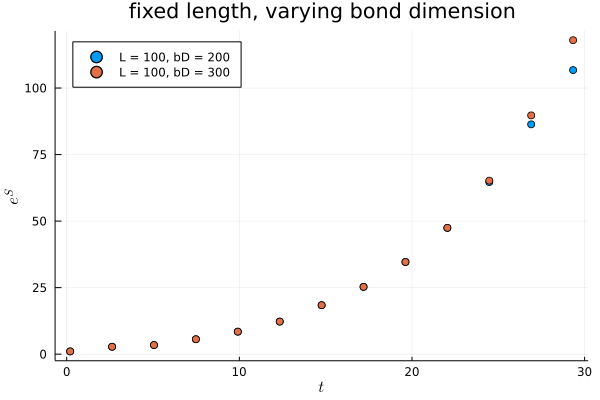

In [17]:
elle = length(Ls)

start = 1
finish = 13

lege = reshape(["L = $(Ls[elle]), bD = $(bDs[i])" for i=1:length(bDs)], (1, length(bDs)))

scatter(times[elle][start:finish], [exp.(entropies[elle][j][start:finish]) for j=1:length(bDs)]
    , label = lege
    , legend = :topleft
    , title = "fixed length, varying bond dimension"
    , ylabel = L"e^S"
    , xlabel = L"t"
)



In [ ]:
#savefig("./img/FIGentropy_TransistorNonint2.pdf")
#savefig("./img/FIGentropy_TransistorInt2.pdf")
#savefig("./img/FIGentropy_DualXX.pdf")

In [ ]:
reliable_timestep = 13
times[end][reliable_timestep]

In [ ]:
bonddim = length(bDs)
lege = reshape(["L = $(Ls[i]), bD = $(bDs[bonddim])" for i=1:length(Ls)], (1, length(Ls)))
scatter(times, [exp.(entropies[k][bonddim]) for k=1:length(Ls)]
    , label = lege
    , legend = :bottomright
    , title = "fixed bond dimension, varying length"
    , ylabel = L"e^S"
    , xlabel = L"t"
)



## Schmidt values

This is probably needed to decide where to cut the state

In [ ]:
elle = length(Ls)
max_schm_values = max_schm_vals.(states[elle][end]);

In [ ]:
start = 1
finish = 13
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:finish], (1, finish-start+1))

plot(
    [[l+.5 for l=1-Ls[elle]/2:Ls[elle]/2-1] for t in times[elle]][start:finish], max_schm_values, xlabel = L"\ell"
    #[[(l+.5)/t for l=1-Ls[elle]/2:Ls[elle]/2-1] for t in times[elle]][start:finish], max_schm_values, xrange = (-1,1), xlabel = L"\ell/t"
    #[[(l+.5)/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2-1] for t in times[elle]][start:finish], max_schm_values, xrange = (-4,4), xlabel = L"\ell/\sqrt{t}"
    , yrange = (findmin(max_schm_values[end])[1]-.1, 0.977)
    , label = lege
)

In [ ]:
elle = length(Ls)
bonddim = length(bDs)

max_schm_values = max_schm_vals.(states[elle][bonddim]);

In [ ]:
nnpursize = nonpurity_length.(max_schm_values)
scatter(times[elle], nnpursize, legend = :bottomright)

## Entropy for each link

In [ ]:
elle = length(Ls)
bonddim = length(bDs)

etrps = [
    [
        bipartite_entropy(states[elle][bonddim][tt], b) for b = 1:Ls[elle]-1
    ]
    for tt = 1:length(times[elle])];



In [ ]:
start = 4
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

scatter(etrps[start:end]
    , label = lege
    , xlabel = L"\ell"
    , ylabel = L"S_\ell"
)

In [ ]:
which_model = "quantum_transistor_L$(Ls[end])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)"

# for laptop:
#wheretosave = "/Users/saveriobocini/numericsvqegrvwefvistics/$(which_model)";
wheretosave = "/Users/saveriobocini/Desktop/$(which_model)";

# for desktop
#wheretosave = "/home/sbocini/Numerics_LabDesktop/full_counted_statistics/$(which_model)";

df = DataFrame([etrps[i][j] for j=1:length(etrps[1]), i=1:length(etrps)], :auto)
rename!(df, Symbol.(times[elle]))
#save("$(wheretosave)_dt$(dt)_bD$(bDs[bonddim]).csv", df)

# Energy-related considerations

## Energy density

In [ ]:
energy_densities = [
    [
        [
            [hamiltonian_density(states[k][j][i], sito) for sito=2:length(states[k][j][i])-1]
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [ ]:
elle = length(Ls)
bonddim = length(bDs)
start = 7
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    [[l/t for l=2-Ls[elle]/2:Ls[elle]/2-1] for t in times[elle]][start:end], 
    real.(energy_densities[elle][bonddim])[start:end]
    , label = lege
    , xrange  = (-3,3)
    , xlabel = L"\ell/t"
    , ylabel = L"<h_\ell>_t"
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim])"
)

## Total energy

$H=\sum_\alpha \sum_{\ell}\sum_{r=1} J_r^\alpha \sigma_\ell^\alpha\sigma_{\ell+r}^\alpha +h\sum_\ell\sigma_\ell^z
$

In [ ]:
energy_total = [
    [
        [
            sum(energy_densities[k][j][i]) + edge_energy(states[k][j][i])
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [ ]:
elle = length(Ls)

siti = siteinds("S=1/2", Ls[elle]);
state_all_up = productMPS(siti, n -> "Up");
psi0 = apply(2 * op("Sx", siti[div(Ls[elle],2)]), state_all_up);
profile0 = real.([hamiltonian_density(psi0, i) for i=2:Ls[elle]-1])
en0 = sum(profile0) + edge_energy(psi0)

lege = reshape(["L = $(Ls[elle]), bD = $(bDs[i])" for i=1:length(bDs)], (1, length(bDs)))

scatter(times[elle], [real.(energy_total[elle][j]) .- en0 for j=1:length(bDs)] 
    , label = lege
    , legend = :topleft
    , title = "fixed length, varying bond dimension"
    , xlabel = L"t"
    , ylabel = L"<H>_t - <H>_0"
)



# Magnetization

## standard (local magn) profile

In [12]:
magnetizations = [
    [
        [
            expect(states[k][j][i], "Sz")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

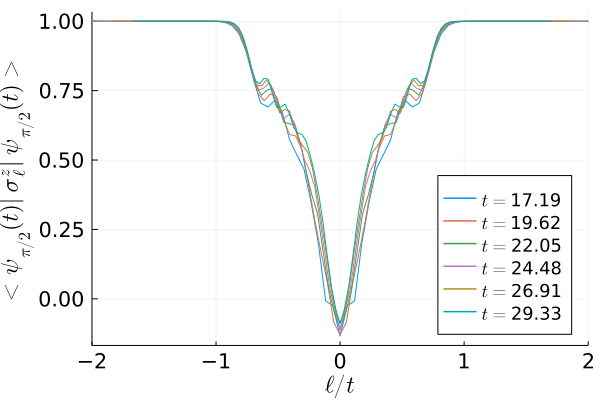

In [13]:
elle = length(Ls)
bonddim = length(bDs)
start = 8
lege = reshape([L"t =" * "$(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:end], 2 .* real.(magnetizations[elle][bonddim])[start:end], xlabel = L"\ell/t", xrange  = (-2,2)
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:end], real.(magnetizations[elle][bonddim])[start:end], xlabel = L"\ell/\sqrt{t}", xrange  = (-7,7)
    , label = lege
    , ylabel = L"<\psi_{\pi/2}(t)|\sigma^z_\ell|\psi_{\pi/2}(t)>"
    , legend = :bottomright
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim])"
    #, markersize = 9.0
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
)

## Total magnetization

This is one of the most useful plots to understand if the behavior of the profile is ballistic or diffusive.

In [14]:
magns_tot = [[
        [
            sum(magnetizations[k][j][i])
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

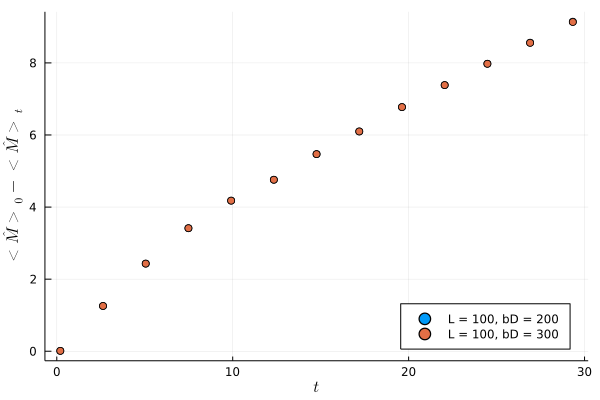

In [15]:
elle = length(Ls)
bonddim = length(bDs)
start = 1
finish = 13
lege = reshape(["L = $(Ls[elle]), bD = $(bDs[i])" for i=1:length(bDs)], (1, length(bDs)))

scatter(times[elle][start:finish], 
    [(div(Ls[elle], 2) - 1) .- magns_tot[elle][bd][start:finish] for bd=1:length(bDs)]
    , legend = :bottomright
    , xlabel = L"t"
    , ylabel = L"<\hat{M}>_0 - <\hat{M}>_t"
    , label = lege
)


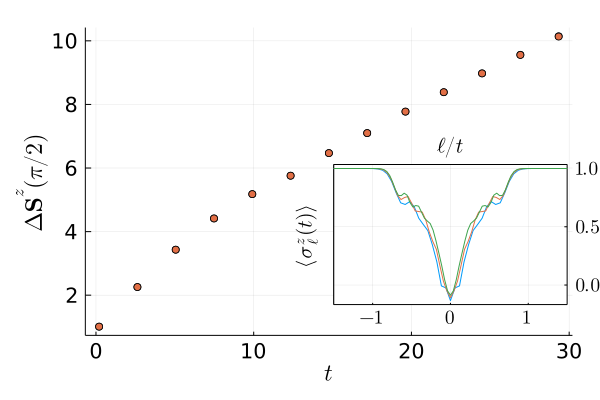

In [30]:
elle = length(Ls)
bonddim = length(bDs)
start = 1
finish = 13
lege = reshape(["L = $(Ls[elle]), bD = $(bDs[i])" for i=1:length(bDs)], (1, length(bDs)))

scatter(times[elle][start:finish], 
    [(div(Ls[elle], 2) ) .- magns_tot[elle][bd][start:finish] for bd=1:length(bDs)]
    , legend = :bottomright
    , xlabel = L"t"
    #, ylabel = L"\langle\Uparrow| \mathbf{S}^z|\Uparrow\rangle - \langle \Psi_{\frac{\pi}{2}}(t)|\mathbf{S}^z|\Psi_{\frac{\pi}{2}}(t)\rangle"
    , ylabel = L"\Delta \mathbf{S}^z(\pi/2)"
    #, label = lege
    , label = ""
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
    , margins = 5Plots.mm
)


elle = length(Ls)
bonddim = length(bDs)
start = 8
finish = 13
lege = reshape([L"t =" * "$(round(times[elle][i], digits=1))" for i=start:2:finish], (1,div(finish-start+1,2)))

# The call for instets is `bbox(x, y, width, height, origin...)`, 
# where numbers are treated as "percent of parent".
# For some reason I need to specify how many plots there are.
plot!(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], 2 .* real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:2:finish], 2 .* real.(magnetizations[elle][bonddim])[start:2:finish], xrange  = (-1.5,1.5), xlabel = L"\ell/t"
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-7,7)
    #, label = lege
    , label = ""
    , ylabel = L"\langle\sigma^z_\ell(t)\rangle"
    , legend = :outerright
    , inset = (1, bbox(-0.07, 0.1, 0.56, 0.455, :bottom, :right))
    , subplot = 2
    , xticks = ([],[L"-2", L"-1", L"0", L"1", L"2"])
    , yticks = ([],[L"0.0", L"0.5", L"1.0"])
    , xmirror = :true
    , xguidefontsize = 14
    , yguidefontsize = 14
)
plot!(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], 2 .* real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:2:finish], 2 .* real.(magnetizations[elle][bonddim])[start:2:finish], xrange  = (-1.5,1.5)#, xlabel = L"\ell/t"
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-7,7)
    #, label = lege
    , label = ""
    , ylabel = L"\langle\sigma^z_\ell(t)\rangle"
    , legend = :outerright
    , inset = (1, bbox(-0.07, 0.1, 0.56, 0.455, :bottom, :right))
    , subplot = 3
    , xticks = ([ -1, 0, 1],[ L"-1", L"0", L"1"])
    , yticks = ([0, 0.5, 1],[L"0.0", L"0.5", L"1.0"])
    , xtickfontsize = 13
    , ytickfontsize = 13
    , box = :on
    , ymirror = :true
)



In [31]:
#savefig("./img/paper_magn_trans_fullglory.pdf")

# Variance-Covariance Matrix

In [ ]:
# Variance-covariance matrix

function VCM(state)
    LL = length(state)
    outpu = zeros(ComplexF64, 3LL,3LL)
    
    paulis = ["Sx","Sy","Sz"]
    
    sigmaexp = [expect(state, σp) for σp in paulis]
    
    for (ii, ope1)=enumerate(paulis),  (jj, ope2)=enumerate(paulis)
        provisory = correlation_matrix(state, ope1, ope2)
        for i=1:LL, j=1:LL
            outpu[LL*(ii-1) + i, LL*(jj-1) + j] = 4*provisory[i,j] - 4*sigmaexp[ii][i]*sigmaexp[jj][j]
        end
    end
    
    outpu
end

## Flip case

In [ ]:
elle = 2
bonddim = 3

for tt in 1:length(times[elle])
    mymat = format.(real.(VCM(states[elle][bonddim][tt])), precision=32)
    df = DataFrame(mymat, :auto)
    save("/Users/saveriobocini/numerics_PhD/VCmatrices/quantum_transistor/StandardNonInt/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_BondDim$(bDs[bonddim])_t$(round(times[elle][tt],digits=2)).csv", 
        df; header=false)
end

## previous shit

In [ ]:
resultsFLIP = []
bondD = 70

for taglia in 16:6:52
    
    sites = siteinds("S=1/2", taglia);
    state_allup = productMPS(sites, "Up");
    
    timeSTART = 1;
    timeSTEPS = 9;

    timeMAX = (taglia/2 - 6) / vmax;
    timeSTEP = (timeMAX - timeSTART) / timeSTEPS;
    
    print("Chain length = $taglia : \n")
    print("initializing step zero \r")
    flush(stdout)

    psi0 = apply(2 * op("Sx", sites[round(Int,taglia/2)]), state_allup);
    evolved = TEBD(psi0, 1E-10, bondD, 0.1, timeSTART);
    provisory = evolved

    print(0,"/",timeSTEPS," time steps done       \r")
    flush(stdout)

    for i in 1:timeSTEPS
        provisory = TEBD(provisory, 1E-10, bondD, 0.1, timeSTEP);
        evolved = vcat(evolved, provisory)
        print(i,"/",timeSTEPS," time steps done         \r")
        flush(stdout)
    end

    print("\n")

    energie, vettori = eigen(VCM(evolved[end]));

    append!(resultsFLIP, [[taglia, real.(energie[end])]])

end



In [ ]:
scatter([resultsFLIP[i][1] for i=1:length(resultsFLIP)], [resultsFLIP[i][2] for i=1:length(resultsFLIP)]
    , legend = :bottomright
    , xlabel = L"L"
    , ylabel = "max eigval"
    , label = ""
)

plot!([resultsFLIP[i][1] for i=1:length(resultsFLIP)], [resultsFLIP[i][2] for i=1:length(resultsFLIP)], label = "")

## Rotated case

In [ ]:
elle = 2
bonddim = 3

for tt in 1:length(times[elle])
    state_all_up = productMPS(siteinds(states[elle][bonddim][tt]), n -> "Up");
    mymat = format.(real.(VCM((states[elle][bonddim][tt] + state_all_up)/sqrt(2))), precision=32)
    df = DataFrame(mymat, :auto)
    save("/Users/saveriobocini/numerics_PhD/VCmatrices/quantum_transistor/CatNonInt/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_BondDim$(bDs[bonddim])_t$(round(times[elle][tt],digits=2)).csv", 
        df; header=false)
end

# Full counting statistics

## Discrete approach

This procedure is based on what Mario did in https://scipost.org/SciPostPhys.12.4.126 .
We need first to compute the **generating function of the moments of the probability distribution**, defined as

$$ G_k^{(\ell)} = <\psi| e^{i \frac{2\pi k}{2\ell+1} \hat{M}_\ell}|\psi>,$$


where $\ell$ is the size of the subsystem on which $\hat{M}$ acts (for the moment, I will consider only even $\ell$ and assume that the subsystem in centered in the origin) and 

$$ \hat{M}_\ell = \sum_{i=-\ell/2 + 1}^{\ell/2} S_i^z.$$

Finally we need to perform the discrete Fourier transform corresponding to 

\begin{equation}
\begin{aligned}
P_\ell(m) &=  \sum_{\alpha=1}^{deg(m)} |<m,\alpha|\psi>|^2 
= \sum_{n}\sum_{\alpha=1}^{deg(m)}\sum_{\beta=1}^{deg(n)} |c_{n,\beta}|^2 |<m,\alpha|n,\beta>|
\\&= \sum_{\alpha=1}^{deg(m)} |c_{m,\alpha}|^2 
= \sum_{n}\sum_{\alpha=1}^{deg(n)}  \delta_{n,m} |c_{n,\alpha}|^2 
= \frac{1}{\ell+1} \sum_{n,\alpha} \sum_{k=-\ell/2}^{\ell/2} e^{i \frac{2\pi k}{2\ell+1} (n-m)} |c_{n,\alpha}|^2
\\&= \frac{1}{\ell+1} \sum_{n,\alpha} \sum_{k=-\ell/2}^{\ell/2} e^{-i \frac{2\pi k}{\ell+1} m} |c_{n,\alpha}|^2 <n,\alpha| e^{i \frac{2\pi k}{\ell+1} \hat{M}_\ell} |n,\alpha>
\\&= \frac{1}{\ell+1} \sum_{n,\alpha}\sum_{n',\alpha'} \sum_{k=-\ell/2}^{\ell/2} e^{-i \frac{2\pi k}{\ell+1} m} c_{n,\alpha}^* c_{n',\alpha'} <n,\alpha| e^{i \frac{2\pi k}{\ell+1} \hat{M}_\ell}|n',\alpha'>
\\&= \frac{1}{\ell+1} \sum_{k=-\ell/2}^{\ell/2} e^{-i \frac{2\pi k}{\ell+1} m} <\psi| e^{i \frac{2\pi k}{\ell+1} \hat{M}_\ell}|\psi>
= \frac{1}{\ell+1} \sum_{k=-\ell/2}^{\ell/2} e^{-i \frac{2\pi k}{\ell+1} m} G^{(\ell)}_k
\end{aligned}
\end{equation}


that is the probability to measure $m$ looking at the observable $\hat{M}_\ell$ if the system is in the state $\psi$. Note that $m$ can only assume semi-integer values; specifically, it assumes values in the interval $\{-\ell/2, -(\ell-1)/2,...,\ell/2\}$. In fact, note that only integer values of $\hat{M}_\ell$ are possible, since we are considering an even number of spins, and I used that in the proof above.

In [ ]:
function eiM(θ, psi, ell) 
    siti = siteinds(psi)
    lunghezza = length(psi)
    outpu = ITensor[]
    for j in siti[- div(ell, 2) + 1 + div(lunghezza, 2) : div(ell, 2) + div(lunghezza, 2)]
        ope = op("Sz", j)
        push!(outpu, exp(2im * pi * θ * ope / (ell + 1)))
    end
    outpu
end

G(state, ell) = [inner(state, apply(eiM(k, state, ell), state)) for k=-div(ell, 2):div(ell, 2)]

In [ ]:
function full_counting_ofZ(state, ell)
    Gk = G(state, ell)
    outpu = ComplexF64[]
    rangeh = div(ell, 2)
    for m = -rangeh:rangeh
        expophase = [exp(- 2im * pi * k * m / (ell + 1)) for k=-rangeh:rangeh]
        push!(outpu, sum(expophase .* Gk) / (ell + 1))
    end
    outpu
end
        

In [ ]:
# check for the initial product state

full_countedZ = real.(full_counting_ofZ(psi0, 6))
scatter([j for j=-div(length(full_countedZ), 2):div(length(full_countedZ), 2)], full_countedZ)

In [ ]:
subsys = 16
elle = 2
bonddim = length(bDs)

full_countedZ = [real(full_counting_ofZ(states[elle][bonddim][i], subsys)) for i=1:length(times[elle])];

In [ ]:
start = 10
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1, length(times[elle]) - start + 1))

scatter([i for i=-div(subsys, 2):div(subsys, 2)], 
    full_countedZ[start:end]
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim]), size(A) = $subsys"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

## Further analysis

Given the full counting statistics, we can compute mean and variance of the distribution. We kinda know that the variance is directly linked to the macroscopic entanglement (if it grows a (system size)^2, or in our case, as time^2 (it is equivalente, given our lightcone structure). 

In [ ]:
function meanFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    sum([j for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end

function varianceFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    mmm = meanFCS(fullcountedstatistics)
    sum([(j - mmm)^2 for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end


In [ ]:
elle = length(Ls)
subsys = Ls[elle]

full_countedZs = [
    [
        real(full_counting_ofZ(states[elle][bd][i], subsys)) 
        for i=1:length(times[elle])
    ] for bd = 1:length(bDs)
];

In [ ]:
bonddim = 4
start = reliable_timestep-1
finish = reliable_timestep
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:finish], (1, finish - start + 1))

scatter([i for i=-div(subsys, 2):div(subsys, 2)], 
    full_countedZs[bonddim][start:finish]
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim]), size(A) = $subsys"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

In [ ]:
#savefig("./img/FIGfullcounting_TransistorNonint.pdf")
#savefig("./img/FIGfullcounting_TransistorInt.pdf")

In [ ]:
mean_magnetizations = [meanFCS.(full_countedZs[bd]) for bd = 1:length(bDs)];
magnetization_variances = [varianceFCS.(full_countedZs[bd]) for bd = 1:length(bDs)];

In [ ]:
lege = reshape(["bD = $(bDs[i])" for i = 1:length(bDs)], (1,length(bDs)))

scatter(times[elle], 
    [(div(Ls[elle], 2) - 1) .- mean_magnetizations[bd] for bd=1:length(bDs)]
    , legend = :bottomright
    , xlabel = L"t"
    , ylabel = L"mean(~\hat{M}_A~; ~|\psi(t)>~) - <\hat{M}_A>_0"
    , label = lege
    , title = "L = $(Ls[elle]), size(A) = $subsys"
)

In [ ]:
lege = reshape(["bD = $(bDs[i])" for i = 1:length(bDs)], (1,length(bDs)))

scatter(times[elle], 
    magnetization_variances
    , legend = :bottomright
    , xlabel = L"t"
    , ylabel = L"Var(~\hat{M}_A~; ~|\psi(t)>~)"
    , label = lege
    , title = "L = $(Ls[elle]), size(A) = $subsys"
)

In [ ]:
#savefig("./img/FIGvariance_TransistorNonint.pdf")
#savefig("./img/FIGvariance_TransistorInt.pdf")

In [ ]:
lege = reshape(["bD = $(bDs[i])" for i = 1:length(bDs)], (1,length(bDs)))

scatter([(div(Ls[elle], 2) - 1) .- mean_magnetizations[bd] for bd=1:2], 
    magnetization_variances
    , legend = :bottomright
    , xlabel = L"M"
    , ylabel = L"Var(~\hat{M}_A~; ~|\psi(t)>~)"
    , label = lege
    , title = "L = $(Ls[elle]), size(A) = $subsys"
)

In [ ]:
#savefig("./img/FIGvarVSmagn_TransistorNonint.pdf")
#savefig("./img/FIGvarVSmagn_TransistorInt.pdf")

In [ ]:
elle = length(Ls)
max_schm_values12 = [max_schm_vals.(states[elle][end-1]), max_schm_vals.(states[elle][end])];
nnpur12 = [nonpurity_length.(max_schm_values12[1]), nonpurity_length.(max_schm_values12[2])]

In [ ]:
lege = reshape(["bD = $(bDs[i])" for i = length(bDs)-1:length(bDs)], (1,2))

scatter(nnpur12, 
    magnetization_variances[end-1,end]
    , legend = :bottomright
    , xlabel = "Non-product-region size"
    , ylabel = L"Var(~\hat{M}_A~; ~|\psi(t)>~)"
    , label = lege
    , title = "L = $(Ls[elle]), size(A) = $subsys"
)

In [ ]:
#savefig("./img/FIGvarVSpurity_TransistorNonint.pdf")
#savefig("./img/FIGvarVSpurity_TransistorInt.pdf")

Let's do a sanity check: the mean magnetizations obtained from the full counted statistics must coincide with the total magnetization computed earlier in this notebook.

In [ ]:
lege = reshape(["bD = $(bDs[i])" for i = 1:length(bDs)], (1,length(bDs)))

scatter(times[elle],
    [mean_magnetizations[length(bDs)] .- magns_tot[elle][bd] for bd = 1:length(bDs)]
    , xlabel = L"t"
    , label = lege
    , legend = :topleft
    , yaxis = "previous magn tot minus new one"
)

### Saving the result

In [ ]:
# for laptop:
whereto = "/Users/saveriobocini/numerics_PhD/full_counted_statistics";

# for desktop
#whereto = "/home/sbocini/Numerics_LabDesktop/full_counted_statistics";

In [ ]:
df = DataFrame([full_countedZs[2][i][j] for j=1:length(full_countedZs[2][1]), i=1:length(full_countedZs[2])], :auto)
rename!(df, Symbol.(times[1]))
save("$(whereto)/Transistor/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_dt$(dt)_bD$(bDs[bonddim]).csv", df)

## Using saved results (FLIP case)

Given the full counting statistics, we can compute mean and variance of the distribution. We kinda know that the variance is directly linked to the macroscopic entanglement (if it grows a (system size)^2, or in our case, as time^2 (it is equivalente, given our lightcone structure). 

In [108]:
function meanFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    sum([j for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end

function varianceFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    mmm = meanFCS(fullcountedstatistics)
    sum([(j - mmm)^2 for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end


varianceFCS (generic function with 1 method)

In [109]:
# for laptop:
whereto = "/Users/saveriobocini/numerics_PhD/full_counted_statistics";

# for desktop
#whereto = "/home/sbocini/Numerics_LabDesktop/full_counted_statistics";

In [110]:
elle = length(Ls)
bonddim1 = length(bDs)-1
bonddim2 = length(bDs)
result_loaded = DataFrame(load("$(whereto)/quantum_transistor/fullglory/L$(Ls[elle])_J$(J)_gamma$(γ)_w$(w)_Delta$(Δ)_Dz$(Dz)_hz$(hz)_dt$(dt)_bD$(bDs[bonddim1]).csv");)
;

imported_times = parse.(Float64, names(result_loaded));
imported_fcs1 = [result_loaded[!, i] for i = 1:length(imported_times)];

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/fullglory/L$(Ls[elle])_J$(J)_gamma$(γ)_w$(w)_Delta$(Δ)_Dz$(Dz)_hz$(hz)_dt$(dt)_bD$(bDs[bonddim2]).csv");)
;
imported_fcs2 = [result_loaded[!, i] for i = 1:length(imported_times)];

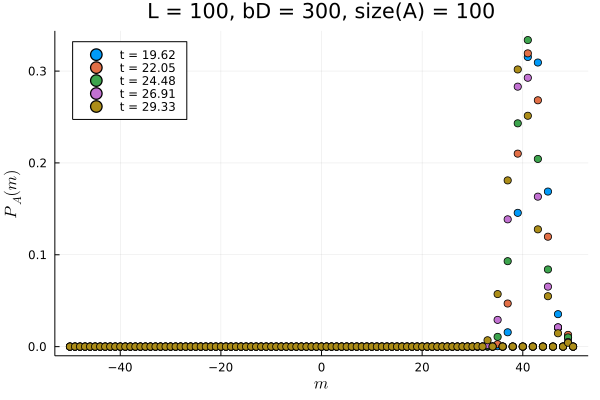

In [111]:
start = 9
finish = 13
lege = reshape(["t = $(round(imported_times[i], digits=2))" for i=start:finish], (1, finish - start + 1))

scatter([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs2[start:finish]
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end])"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

In [112]:
#savefig("./img/FIGfullcounting_TransistorNonint2.pdf")
#savefig("./img/FIGfullcounting_TransistorInt2.pdf")
#savefig("./img/FIGfullcounting_DualXX.pdf")

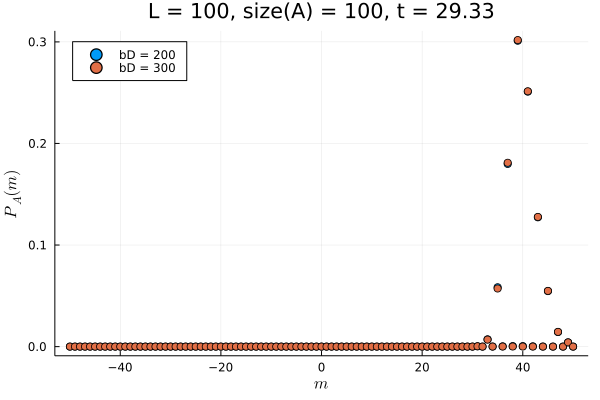

In [113]:
tt = 13

scatter([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs1[tt]
    , label = "bD = $(bDs[end-1])"
    , legend = :topleft
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end]), t = $(round(imported_times[tt], digits=2))"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

scatter!([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs2[tt]
    , label = "bD = $(bDs[end])"
)

In [114]:
[sum(imported_fcs1[tt]), sum(imported_fcs2[tt])]

2-element Vector{Float64}:
 0.999726847921834
 0.9999342782962971

In [115]:
#savefig("./img/FIGfullcountingSTABILITY_TransistorNonint2.pdf")
#savefig("./img/FIGfullcountingSTABILITY_TransistorInt2.pdf")
#savefig("./img/FIGfullcountingSTABILITY_DualXX.pdf")

In [116]:
mean_magnetization1 = meanFCS.(imported_fcs1) 
magnetization_variance1 = varianceFCS.(imported_fcs1) 

mean_magnetization2 = meanFCS.(imported_fcs2) 
magnetization_variance2 = varianceFCS.(imported_fcs2) ;

In [ ]:
start = 1
finish = 7

scatter(times[length(Ls)][start:finish], 
    magnetization_variance1[start:finish]
    , legend = :bottomright
    , xlabel = L"t"
    , ylabel = L"Var(~\hat{M}_A~; ~|\psi(t)>~)"
    , label = "bD = $(bDs[end-1])"
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end])"
    , yrange = (-0.1, magnetization_variance2[finish]+0.5)
)

scatter!(times[length(Ls)][start:finish], 
    magnetization_variance2
    , label = "bD = $(bDs[end])"
)

In [ ]:
#savefig("./img/FIGvariance_TransistorNonint2.pdf")
#savefig("./img/FIGvariance_TransistorInt2.pdf")
#savefig("./img/FIGvariance_DualXX.pdf")

In [ ]:
elle = length(Ls)
max_schm_values12 = [max_schm_vals.(states[elle][end-1]), max_schm_vals.(states[elle][end])];
nnpur12 = [nonpurity_length.(max_schm_values12[1]), nonpurity_length.(max_schm_values12[2])]

In [ ]:
start = 1
finish = 13

scatter(nnpur12[1][start:finish], 
    magnetization_variance1[start:finish]
    , legend = :bottomright
    , xlabel = "Non-product-region size"
    , ylabel = L"Var(~\hat{M}_A~; ~|\psi(t)>~)"
    , label = "bD = $(bDs[end-1])"
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end])"
)

scatter!(nnpur12[2][start:finish], 
    magnetization_variance2[start:finish]
    , label = "bD = $(bDs[end])"
    , legend=:bottomright
)

In [ ]:
#savefig("./img/FIGvarVSpurity_TransistorNonint2.pdf")
#savefig("./img/FIGvarVSpurity_TransistorInt2.pdf")
#savefig("./img/FIGvarVSpurity_DualXX.pdf")

### Alternative representations

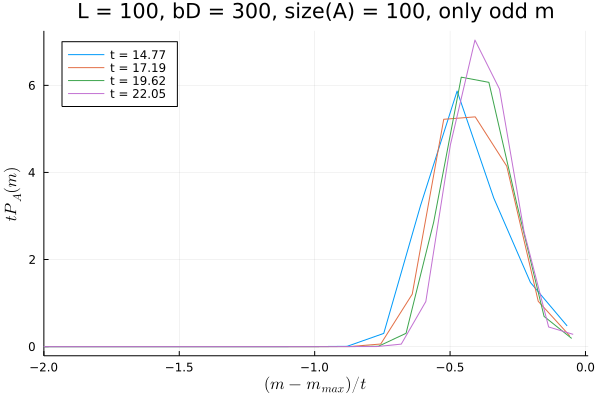

In [117]:
start = 7
finish = 10
lege = reshape(["t = $(round(imported_times[i], digits=2))" for i=start:finish], (1, finish - start + 1))

plot([[(i-Ls[elle]/2)/rr for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)] for rr in times[elle][start:finish]], 
    [imported_fcs2[rr][2:2:end] * times[elle][rr] for rr in start:finish] 
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"(m-m_{max})/t"
    , ylabel = L"tP_A(m)"
    , xrange = (-2,0.01)
)

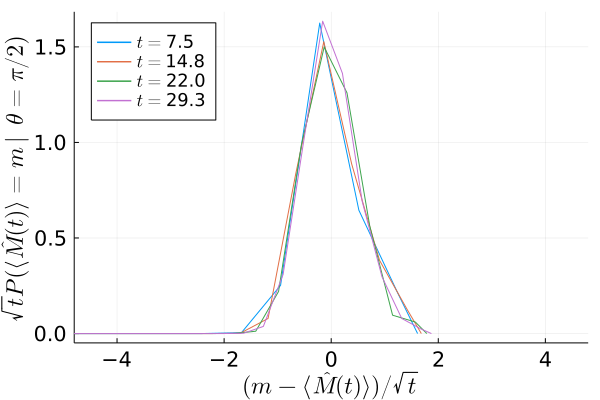

In [118]:
start = 4
finish = 13
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:3:finish], (1, 1+div(finish - start + 1,3)))

plot([vcat([(i - mean_magnetization2[rr]) / sqrt(times[elle][rr]) 
                for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)], 
            (Ls[elle]/2 - mean_magnetization2[rr]) / sqrt(times[elle][rr])
            ) 
        for rr in start:3:finish], 
    [vcat(imported_fcs2[rr][2:2:end],
            imported_fcs2[rr][end]  
            ) * sqrt(times[elle][rr]) 
        for rr in start:3:finish] 
    , label = lege
    , legend = :topleft
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"(m-\langle\hat{M}(t)\rangle)/\sqrt{t}"
    , ylabel = L"\sqrt{t}P(\langle\hat{M}(t)\rangle = m~|~\theta=\pi/2)"
    , xrange = (-4.8, 4.8)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
)

In [ ]:
#savefig("poster_fcsFlip.pdf")

## Using saved results (ROTATED case)

In [119]:
function meanFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    sum([j for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end

function varianceFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    mmm = meanFCS(fullcountedstatistics)
    sum([(j - mmm)^2 for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end


varianceFCS (generic function with 1 method)

In [120]:
# for laptop:
whereto = "/Users/saveriobocini/numerics_PhD/full_counted_statistics_CAT";

# for desktop
#whereto = "/home/sbocini/Numerics_LabDesktop/full_counted_statistics_CAT";

In [121]:
elle = length(Ls)
bonddim1 = length(bDs)-1
bonddim2 = length(bDs)

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/standard/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_dt$(dt)_bD$(bDs[bonddim1]).csv");)
;

imported_times = parse.(Float64, names(result_loaded));
imported_fcs1cat = [result_loaded[!, i] for i = 1:length(imported_times)];

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/standard/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_dt$(dt)_bD$(bDs[bonddim2]).csv");)
;
imported_fcs2cat = [result_loaded[!, i] for i = 1:length(imported_times)];

LoadError: UndefVarError: Jx not defined

In [ ]:
start = length(imported_times)-3
finish = length(imported_times)-1
lege = reshape(["t = $(round(imported_times[i], digits=2))" for i=start:finish], (1, finish - start + 1))

scatter([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs2cat[start:finish]
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end])"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

In [ ]:
tt = length(imported_times)-1

scatter([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs1cat[tt]
    , label = "bD = $(bDs[end-1])"
    , legend = :topleft
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end]), t = $(round(imported_times[tt], digits=2))"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

scatter!([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs2cat[tt]
    , label = "bD = $(bDs[end])"
)

In [ ]:
[sum(imported_fcs1cat[tt]), sum(imported_fcs2cat[tt])]

In [ ]:
mean_magnetization1cat = meanFCS.(imported_fcs1cat) 
magnetization_variance1cat = varianceFCS.(imported_fcs1cat) 

mean_magnetization2cat = meanFCS.(imported_fcs2cat) 
magnetization_variance2cat = varianceFCS.(imported_fcs2cat) ;

In [ ]:
start = 1
finish = 13

scatter(times[length(Ls)][start:finish], 
    magnetization_variance1cat[start:finish]
    , legend = :bottomright
    , xlabel = L"t"
    , ylabel = L"Var(~\hat{M}_A~; ~|\psi(t)>~)"
    , label = "bD = $(bDs[end-1])"
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end])"
)

scatter!(times[length(Ls)][start:finish], 
    magnetization_variance2cat
    , label = "bD = $(bDs[end])"
)

In [ ]:
elle = length(Ls)
max_schm_values12 = [max_schm_vals.(states[elle][end-1]), max_schm_vals.(states[elle][end])];
nnpur12cat = [nonpurity_length.(max_schm_values12[1]), nonpurity_length.(max_schm_values12[2])]

In [ ]:
start = 1
finish = 13

scatter(nnpur12cat[1][start:finish], 
    magnetization_variance1cat[start:finish]
    , legend = :bottomright
    , xlabel = "Non-product-region size"
    , ylabel = L"Var(~\hat{M}_A~; ~|\psi(t)>~)"
    , label = "bD = $(bDs[end-1])"
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end])"
)

scatter!(nnpur12cat[2][start:finish], 
    magnetization_variance2cat[start:finish]
    , label = "bD = $(bDs[end])"
    , legend=:bottomright
)

In [ ]:
start = 1
finish = 13

scatter(nnpur12[2][start:finish], 
    magnetization_variance1[start:finish]
    , legend = :topleft
    , xlabel = L"||\Omega_{0.98}||"
    , ylabel = L"Var(~\hat{M})"
    , label = L"\theta=\pi/2 \quad(Var\sim t)"
    #, title = "L = $(Ls[elle]), size(A) = $(Ls[end])"
    , markersize = 9.0
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 14
)

scatter!(nnpur12cat[2][start:finish], 
    magnetization_variance2cat[start:finish]
    , label = L"\theta=\pi/4 \quad(Var\sim t^2)"
    , markersize = 9.0
)

In [ ]:
#savefig("poster_variance.pdf")

### Alternative representations

In [ ]:
start = 7
finish = 13
lege = reshape(["t = $(round(imported_times[i], digits=2))" for i=start:finish], (1, finish - start + 1))

plot([[(i-Ls[elle]/2)/rr for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)] for rr in times[elle][start:finish]], 
    [imported_fcs2cat[rr][2:2:end] * times[elle][rr] for rr in start:finish] 
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"(m-m_{max})/t"
    , ylabel = L"tP_A(m)"
    , xrange = (-2,0.01)
)

In [107]:
start = 4
finish = 13
lege = reshape([L"t=" * "$(round(imported_times[i], digits=1))" for i=start:3:finish], (1, 1+div(finish - start + 1,3)))

plot([vcat([(i - mean_magnetization2cat[rr]) / sqrt(times[elle][rr]) 
                for i=-div(Ls[elle], 2)+1:2:div(Ls[elle], 2)], 
            (Ls[elle]/2 - mean_magnetization2cat[rr]) / sqrt(times[elle][rr])
            ) 
        for rr in start:3:finish], 
    [vcat(imported_fcs2cat[rr][2:2:end],
            imported_fcs2cat[rr][end]  
            ) * sqrt(times[elle][rr]) 
        for rr in start:3:finish] 
    , label = lege
    , legend = :topleft
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"(m-<\hat{M}(t)>)/\sqrt{t}"
    , ylabel = L"\sqrt{t}P(\hat{M}\leadsto m~|~\theta=\pi/4)"
    , xrange = (-5,5)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 16
    , yguidefontsize = 16
    , legendfontsize = 12
)

LoadError: UndefVarError: mean_magnetization2cat not defined

In [ ]:
#savefig("poster_fcsCat.pdf")

# Quantum Fisher

This uses the results obtained from the Mathematica algorithm written by Mau.

In [21]:
# for laptop:
#whereto = "/Users/saveriobocini/numerics_PhD/fishers";

# for desktop
whereto = "/home/sbocini/Numerics_LabDesktop/fishers";

In [22]:
elle = length(Ls)

QFI_flip = CSV.read("$(whereto)/quantum_transistor/fullglory/L$(Ls[elle])_J$(J)_gamma$(γ)_w$(w)_Delta$(Δ)_Dz$(Dz)_hz$(hz)_BondDim$(bDs[end])_dt$(dt)_FLIP.csv", DataFrame, header=0)

QFI_cat = CSV.read("$(whereto)/quantum_transistor/fullglory/L$(Ls[elle])_J$(J)_gamma$(γ)_w$(w)_Delta$(Δ)_Dz$(Dz)_hz$(hz)_BondDim$(bDs[end])_dt$(dt)_CAT.csv", DataFrame, header=0);



In [23]:
start = 3
finish = 12

m(t, p) = p[1] .+ p[2] * t + p[3] ./ t
p0 = [0.5, 0.5, 0.5]
fitte1 = curve_fit(m, QFI_flip.Column1[start:finish], QFI_flip.Column2[start:finish], p0);
fit_flip(t) = m(t, fitte1.param);

m(t, p) = p[1] .+ p[2] * t + p[3] ./ t
p0 = [0.5, 0.5, 0.5]
fitte2 = curve_fit(m, QFI_cat.Column1[start:finish], QFI_cat.Column2[start:finish], p0);
fit_cat(t) = m(t, fitte2.param);

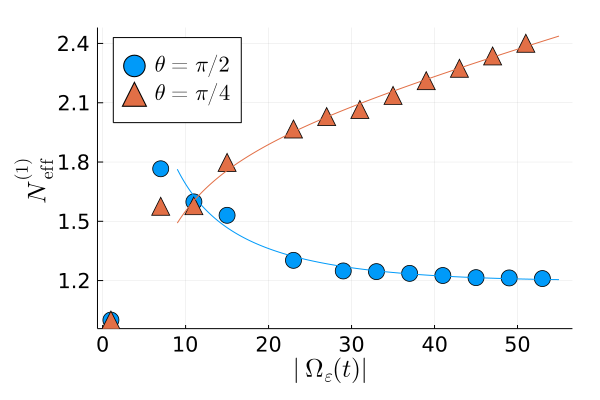

In [26]:
scatter(QFI_flip.Column1, QFI_flip.Column2
    , label = L"\theta=\pi/2"
    , legend = :topleft
    #, title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end]), only odd m"
    , xlabel = L"|\Omega_\epsilon(t)|"
    , ylabel = L"N_{\mathrm{eff}}^{(1)}"
    #, xrange = (-4.8, 4.8)
    , xtickfontsize = 14
    , ytickfontsize = 14
    , xguidefontsize = 17
    , yguidefontsize = 17
    , legendfontsize = 15
    , markersize = 9
    , margins = 5Plots.mm
)

scatter!(QFI_cat.Column1, QFI_cat.Column2
    , label = L"\theta=\pi/4"
    , markersize = 9
    , shape = :utriangle
)

leftone = findmin([QFI_flip.Column1[3], QFI_cat.Column1[3]])[1] - 2
rightone = findmax([QFI_flip.Column1[end], QFI_cat.Column1[end]])[1] + 2

plot!(leftone:0.01:rightone, fit_flip(leftone:0.01:rightone)
    , label = ""
    , color = 1
)

plot!(leftone:0.01:rightone, fit_cat(leftone:0.01:rightone)
    , label = ""
    , color = 2
)



In [27]:
#savefig("img/paper_fisher_fullglory.pdf")

# Full counting for staggered magnetization

## Dual XX

In [ ]:
# this is (one of) the integrable option: it corresponds to the dual XX chain

Jx = 0.7
Jy = 0.0 
Jz = 0.0
h = 0.0
dt = 0.01;

Ls = [160]
bDs = [240, 300];


# for laptop:
base_path = "/Users/saveriobocini/numerics_PhD/quantum_transistor/standard";

# for desktop
#base_path = "/home/sbocini/Numerics_LabDesktop/quantum_transistor/standard";


times = [
    load("$(base_path)/L$(L)_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_BondDim$(bDs[1])_dt$(dt).jld2"
    , "times") for L in Ls
];

In [ ]:
function meanFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    sum([j for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end

function varianceFCS(fullcountedstatistics)
    ell = length(fullcountedstatistics)
    mmm = meanFCS(fullcountedstatistics)
    sum([(j - mmm)^2 for j=-div(ell,2):div(ell,2)] .* fullcountedstatistics)
end


In [ ]:
# for laptop:
whereto = "/Users/saveriobocini/numerics_PhD/full_counted_statistics_stagZ";

# for desktop
#whereto = "/home/sbocini/Numerics_LabDesktop/full_counted_statistics_stagZ";

In [ ]:
elle = length(Ls)
bonddim1 = length(bDs)-1
bonddim2 = length(bDs)

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/standard/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_dt$(dt)_bD$(bDs[bonddim1]).csv");)
;

imported_times = parse.(Float64, names(result_loaded));
imported_fcs1 = [result_loaded[!, i] for i = 1:length(imported_times)];

result_loaded = DataFrame(load("$(whereto)/quantum_transistor/standard/L$(Ls[elle])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_dt$(dt)_bD$(bDs[bonddim2]).csv");)
;
imported_fcs2 = [result_loaded[!, i] for i = 1:length(imported_times)];

In [ ]:
start = 11
finish = 13
lege = reshape(["t = $(round(imported_times[i], digits=2))" for i=start:finish], (1, finish - start + 1))

scatter([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs2[start:finish]
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim2]), size(A) = $(Ls[end])"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

In [ ]:
tt = length(imported_times)

scatter([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs1[tt]
    , label = "bD = $(bDs[end-1])"
    , legend = :topleft
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end]), t = $(round(imported_times[tt], digits=2))"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

scatter!([i for i=-div(Ls[elle], 2):div(Ls[elle], 2)], 
    imported_fcs2[tt]
    , label = "bD = $(bDs[end])"
)

In [ ]:
[sum(imported_fcs1[tt]), sum(imported_fcs2[tt])]

In [ ]:
mean_STAGmagnetization1 = meanFCS.(imported_fcs1) 
STAGmagnetization_variance1 = varianceFCS.(imported_fcs1) 

mean_STAGmagnetization2 = meanFCS.(imported_fcs2) 
STAGmagnetization_variance2 = varianceFCS.(imported_fcs2) ;

In [ ]:
start = 1
finish = 13

scatter(times[length(Ls)][start:finish], 
    STAGmagnetization_variance1[start:finish]
    , legend = :bottomright
    , xlabel = L"t"
    , ylabel = L"Var(~\hat{M}^{stag}_A~; ~|\psi(t)>~)"
    , label = "bD = $(bDs[end-1])"
    , title = "L = $(Ls[elle]), size(A) = $(Ls[end])"
)

scatter!(times[length(Ls)][start:finish], 
    STAGmagnetization_variance2
    , label = "bD = $(bDs[end])"
)

# Full counting of X

In [ ]:
function eiM_forX(θ, psi, ell) 
    siti = siteinds(psi)
    lunghezza = length(psi)
    outpu = ITensor[]
    for j in siti[- div(ell, 2) + 1 + div(lunghezza, 2) : div(ell, 2) + div(lunghezza, 2)]
        ope = op("Sx", j)
        push!(outpu, exp(2im * pi * θ * ope / (ell + 1)))
    end
    outpu
end

G_forX(state, ell) = [inner(state, apply(eiM_forX(k, state, ell), state)) for k=-div(ell, 2):div(ell, 2)]

In [ ]:
function full_counting_ofX(state, ell)
    Gk = G_forX(state, ell)
    outpu = ComplexF64[]
    rangeh = div(ell, 2)
    for m = -rangeh:rangeh
        expophase = [exp(- 2im * pi * k * m / (ell + 1)) for k=-rangeh:rangeh]
        push!(outpu, sum(expophase .* Gk) / (ell + 1))
    end
    outpu
end
        

In [ ]:
elle = 2
subsys = Ls[elle]
bonddim = 3

full_countedXs = [
    [
        real(full_counting_ofX(states[elle][bd][i], subsys)) 
        for i=1:length(times[elle])
    ] for bd = bonddim:bonddim
];

In [ ]:
start = 1
finish = 8
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:finish], (1, finish - start + 1))

scatter([i for i=-div(subsys, 2):div(subsys, 2)], 
    full_countedXs[end][start:finish]
    , label = lege
    , legend = :topleft
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim]), size(A) = $subsys"
    , xlabel = L"m"
    , ylabel = L"P_A(m)"
)

# Evolving first with Ising

## Loading states

In [ ]:
Jx = 0.7
Jy = 0.14 # Jx/5
Jz = 0.0
h = 0.35 # Jx/2
dt = 0.01;

Ls = [40]
bDs = [400];

In [ ]:
Jx = 0.7
Jy = 0.14 # Jx/5
Jz = 0.0
h = 0.35 # Jx/2
dt = 0.01;
Dy = 0.21

Ls = [60]
bDs = [300];



In [ ]:
# for laptop:
base_path = "/Users/saveriobocini/numerics_PhD/quantum_transistor/after_ising";

# for desktop
#base_path = "/home/sbocini/Numerics_LabDesktop/quantum_transistor/after_ising";


times = [
    load("$(base_path)/L$(L)_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_BondDim$(bDs[1])_dt$(dt).jld2"
    , "times") for L in Ls
];

states = [
    [
        [
            load("$(base_path)/L$(Ls[k])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_BondDim$(bDs[j])_dt$(dt).jld2"
                , "t$(round(times[k][i], digits=3))")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [ ]:
# for laptop:
base_path = "/Users/saveriobocini/numerics_PhD/quantum_transistor/after_ising_dirty";

# for desktop
#base_path = "/home/sbocini/Numerics_LabDesktop/quantum_transistor/after_ising_dirty";

times_dirty = [
    load("$(base_path)/L$(L)_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_BondDim$(bDs[1])_dt$(dt)_Dy$(Dy).jld2"
    , "times") for L in Ls
];

states_dirty = [
    [
        [
            load("$(base_path)/L$(Ls[k])_Jx$(Jx)_Jy$(Jy)_Jz$(Jz)_h$(h)_BondDim$(bDs[j])_dt$(dt)_Dy$(Dy).jld2"
                , "t$(round(times_dirty[k][i], digits=3))")
            for i=1:length(times_dirty[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

## Magnetization

In [ ]:
magnetizations = [
    [
        [
            expect(states[k][j][i], "Sz")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [ ]:
elle = length(Ls)
bonddim = length(bDs)
start = 2
finish = 4
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/t", xrange  = (-3,3)
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], real.(magnetizations[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-9,9)
    , label = lege
    , ylabel = L"<S^z_\ell>_t"
    , legend = :bottomright
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim])"
)

In [ ]:
magnetizations_dirty = [
    [
        [
            expect(states_dirty[k][j][i], "Sz")
            for i=1:length(times_dirty[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [ ]:
elle = length(Ls)
bonddim = length(bDs)
start = 2
finish = 4
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    #[[l for l=1-Ls[elle]/2:Ls[elle]/2] for t in times_dirty[elle]][start:finish], real.(magnetizations_dirty[elle][bonddim])[start:finish], xlabel = L"\ell"
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times_dirty[elle]][start:finish], real.(magnetizations_dirty[elle][bonddim])[start:finish], xlabel = L"\ell/t", xrange  = (-3,3)
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times_dirty[elle]][start:finish], real.(magnetizations_dirty[elle][bonddim])[start:finish], xlabel = L"\ell/\sqrt{t}", xrange  = (-9,9)
    , label = lege
    , ylabel = L"<S^z_\ell>_t"
    , legend = :bottomright
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim]), Dy = $(Dy)"
)

## Other local observables

In [ ]:
elle = length(Ls)
bonddim = length(bDs)

XXcorrs = [
    [
        real(XXcorr(states[elle][bonddim][t], i, i+1))
        for i = 1:Ls[elle]-1
    ] for t = 1:length(times[elle])
];

In [ ]:
start = 1
finish = 5
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:length(times[elle])], (1,length(times[elle])-start+1))

plot(
    [[l+0.5 for l=1-Ls[elle]/2:Ls[elle]/2-1] for t in times[elle]][start:end], XXcorrs
    , label = lege
    , xlabel = L"i"
    , ylabel = L"<S^x_i S^x_{i+1}>_t"
)

## Energy

In [ ]:
tot_energies = [inner(states[end][end][i], apply(H_tobeapplied(states[end][end][i]), states[end][end][i])) for i = 1:length(states[end][end])]
;

In [ ]:
scatter(times[end], real.(tot_energies) .- real.(tot_energies[1])
    , xlabel = L"t"
    , ylabel = L"E_{tot}(t) - E_{tot}(0)"
    , label = ""
)

# RANDOM couplings

In [ ]:
dt = 0.01;

Ls = [60]
bDs = [40];

In [ ]:
dt = 0.01;

Ls = [40]
bDs = [40];

In [ ]:
tabb = [[["$(colons)","$(rows)"] for rows in bDs] for colons in Ls]

In [ ]:
jxes = load("$(base_path)/RANDOM_L$(Ls[1])_BondDim$(bDs[1])_dt$(dt).jld2", "Jx");
jyes = load("$(base_path)/RANDOM_L$(Ls[1])_BondDim$(bDs[1])_dt$(dt).jld2", "Jy");
hacs = load("$(base_path)/RANDOM_L$(Ls[1])_BondDim$(bDs[1])_dt$(dt).jld2", "h");

In [ ]:
scatter(jxes, label = "Jx", xlabel = L"\ell")
scatter!(jyes, label = "Jy")
scatter!(hacs, label = "h")

In [ ]:
times = [
    load("$(base_path)/RANDOM_L$(L)_BondDim$(bDs[1])_dt$(dt).jld2"
    , "times") for L in Ls
    ];

In [ ]:
states = [
    [
        [
            load("$(base_path)/RANDOM_L$(Ls[k])_BondDim$(bDs[j])_dt$(dt).jld2"
                , "t$(round(times[k][i], digits=3))")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [ ]:
magnetizations = [
    [
        [
            expect(states[k][j][i], "Sz")
            for i=1:length(times[1])
        ] for j=1:length(bDs)
    ] for k=1:length(Ls)
];

In [ ]:
elle = length(Ls)
bonddim = length(bDs)
start = 5
finish = 10
lege = reshape(["t = $(round(times[elle][i], digits=2))" for i=start:finish], (1, finish-start+1))

plot(
    [[l/t for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], magnetizations[elle][bonddim][start:finish], xrange  = (-3,3), xlabel = L"\ell/t"
    #[[l/sqrt(t) for l=1-Ls[elle]/2:Ls[elle]/2] for t in times[elle]][start:finish], magnetizations[elle][bonddim][start:finish], xrange  = (-6,6), xlabel = L"\ell/\sqrt{t}"
    #magnetizations[elle][bonddim][start:finish], xlabel = L"\ell"
    , label = lege
    , ylabel = L"<S^z_\ell>_t"
    , legend = :bottomright
    , title = "L = $(Ls[elle]), bD = $(bDs[bonddim])"
)